In [ ]:
!pip install -q -U keras-nlp keras datasets kagglehub keras_hub 
!pip install -q -U tensorflow-text
# Install tensorflow-cpu so tensorflow does not attempt to access the TPU.
!pip install -q -U tensorflow-cpu
!pip install -q -U wandb

In [2]:
import jax
jax.devices()

E0000 00:00:1735492039.290019      74 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
E1229 17:07:19.328749401      74 oauth2_credentials.cc:238]            oauth_fetch: UNKNOWN:C-ares status is not ARES_SUCCESS qtype=A name=metadata.google.internal. is_balancer=0: Domain name not found {grpc_status:2, created_time:"2024-12-29T17:07:19.328732956+00:00"}


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [3]:
import os
# Set the environment variables for Kaggle and Weights & Biases.
# from kaggle_secrets import UserSecretsClient
# from google.colab import userdata
#import getpass
os.environ["KAGGLE_USERNAME"] = "your-username"# or UserSecretsClient().get_secret(KAGGLE_USERNAME) or userdata.get(KAGGLE_USERNAME) or getpass.getpass("Enter your KAGGLE_USERNAME: ")
os.environ["KAGGLE_KEY"] = "kaggle-api-key" # or UserSecretsClient().get_secret(KAGGLE_KEY) or userdata.get(KAGGLE_KEY) or getpass.getpass("Enter your  KAGGLE_KEY: ")
os.environ["WANDB_API_KEY"] = "wand-api-key" # or UserSecretsClient().get_secret(WANDB_API_KEY) or userdata.get(WANDB_API_KEY) or getpass.getpass("Enter your WANDB_API_KEY: ")
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

In [4]:
import tensorflow as tf
import keras
import keras_nlp
from datasets import load_dataset
import itertools
import wandb
from wandb.integration.keras import WandbMetricsLogger

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data = load_dataset("allenai/c4", "ja", streaming=True)

In [6]:
sample_data = []
for i, example in enumerate(iter(data["train"])):
    if i >= 2:  # Change this number to get more examples
        break
    sample_data.append(example["text"])

print("Sample Japanese Data:")
for i, text in enumerate(sample_data):
    print(f"Example {i + 1}:", text[:500])  # Print the first 500 characters to get a preview

Sample Japanese Data:
Example 1: 生八つ橋のタグまとめ | エキサイトブログ
生八つ橋のタグまとめ
「生八つ橋」のタグがついている新着記事と人気記事をまとめました。エキサイトブログには生八つ橋に関連するブログ（日記、記録、写真、レビュー、噂、まとめ）がたくさん投稿されています。
「生八つ橋」タグの記事（4）
生八つ橋いろいろ
京都旅行のお土産(我が家用)に色々な生八つ橋を買ってきました。我が家はみんな八つ橋ファンなのです～。地元の方達や京都を案内してくれたYさんは「八つ橋なんてもう何年も食べたことないわ～～～」と仰っていましたが、いやいや、美味しいですよ～～！！私は大好きです！まぁ確かに私は東京出身ですが、雷おこしや人形焼きは食べませんからね～。それと同じことでしょうか＾＾；とはいえ、舟和の芋ようかんや東京ばな奈...
2020/03/06 23:54 - ＮＹの小さな灯り　～ヘアメイク日記～
黒糖きな粉
冬限定の生八つ橋「ふゆおたべ」
日本から戻る時に大抵空港で生八つ橋か信玄餅のどちらかを必ず買って帰ってくるのですが、今回は珍しいバージョンを見かけたので生八つ橋を買う事にしました。それがこちら、冬限定の生八つ橋「ふゆ
Example 2: 廃棄物をチップ／ペレットに - Gneuss
フィルム、繊維、更には市場回収品であるPETボトルフレークなどのリサイクル可能な廃棄物は、高水準の純度で高品質ペレット/チップに加工し、生産押出機でバージン材料と混ぜることができます。
Startseite アプリケーション例 Granulat & Regranulat
繊維、フィルムやダンゴなどのリサイクル可能な廃棄物は、シュレッダーに入れられ、金属セパレーター付コンベアでアジエータ―を搭載した容器に投入されます。そこから、材料はオーガや詰め込みフィーダーによって押出機に運ばれます。
あるいは、サイズを圧縮し塊となったリサイクル可能な廃棄物は、MRS押出機に直接入れることができます。サイズ圧縮と押し出しの処理工程を切り離すことの長所は、材料の投下（そしてさらにスループット率も）が均一にされ、そして、金属は材料フローから確実に排出されるところにあります。このシステムを統合化システム上で達成することは、一般的に非常に難しいです。
押出機はゆっくりとポリエ

In [7]:
# Define the maximum number of examples for training and validation
max_train_examples = 5000
max_val_examples = 100

# Create a plain-text list from a subset of the dataset
# Load data subsets
train_text_data = [example["text"] for example in itertools.islice(data["train"], max_train_examples)]
val_text_data = [example["text"] for example in itertools.islice(data["validation"], max_val_examples)]

# Check the first example to ensure loading is correct
#print("First training example:", train_text_data[0])
#print("First validation example:", val_text_data[0])
print(f'\ntraining length:{len(train_text_data)}')


training length:5000


In [8]:
batch_size = 4

# Convert the lists of text data to TensorFlow datasets
train_data = tf.data.Dataset.from_tensor_slices(train_text_data)
val_data = tf.data.Dataset.from_tensor_slices(val_text_data)

# Preprocess each text sample
def preprocess_text(text):
    return tf.convert_to_tensor(text, dtype=tf.string)

# Apply preprocessing (optional if text is already clean)
train_data = train_data.map(preprocess_text)
val_data = val_data.map(preprocess_text)

# Shuffle and batch the training data
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size)
val_data = val_data.batch(batch_size)

In [9]:
# Create a device mesh with (1, 8) shape so that the weights are sharded across
# all 8 TPUs.
device_mesh = keras.distribution.DeviceMesh(
    (1, 8),
    ["batch", "model"],
    devices=keras.distribution.list_devices(),
)

model_dim = "model"

layout_map = keras.distribution.LayoutMap(device_mesh)

# Weights that match 'token_embedding/embeddings' will be sharded on 8 TPUs
layout_map["token_embedding/embeddings"] = (model_dim, None)
# Regex to match against the query, key and value matrices in attention layers
layout_map["decoder_block.*attention.*(query|key|value)/kernel"] = (model_dim, None, None)
layout_map["decoder_block.*attention_output/kernel"] = (model_dim, None, None)
layout_map["decoder_block.*ffw_gating.*/kernel"] = (None, model_dim)
layout_map["decoder_block.*ffw_linear/kernel"] = (model_dim, None)

model_parallel = keras.distribution.ModelParallel(
    layout_map=layout_map,
    batch_dim_name="batch",
)

keras.distribution.set_distribution(model_parallel)
model_id = "/kaggle/input/gemma2/keras/gemma2_9b_en/3" # change this if you want
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 3584)        │   9,241,705,984 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     917,504,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 9,241,705,984 (34.43 GB)

 Trainable params: 9,241,705,984 (34.43 GB)

 Non-trainable params: 0 (0.00 B)

In [10]:
decoder_block_1 = gemma_lm.backbone.get_layer('decoder_block_1')
print(type(decoder_block_1))
for variable in decoder_block_1.weights:
  print(f'{variable.path:<48}  {str(variable.shape):<14}  {str(variable.value.sharding.spec)}')

<class 'keras_hub.src.models.gemma.gemma_decoder_block.GemmaDecoderBlock'>
decoder_block_1/pre_attention_norm/scale          (3584,)         PartitionSpec(None,)
decoder_block_1/post_attention_norm/scale         (3584,)         PartitionSpec(None,)
decoder_block_1/attention/query/kernel            (16, 3584, 256)  PartitionSpec('model', None, None)
decoder_block_1/attention/key/kernel              (8, 3584, 256)  PartitionSpec('model', None, None)
decoder_block_1/attention/value/kernel            (8, 3584, 256)  PartitionSpec('model', None, None)
decoder_block_1/attention/attention_output/kernel  (16, 256, 3584)  PartitionSpec('model', None, None)
decoder_block_1/pre_ffw_norm/scale                (3584,)         PartitionSpec(None,)
decoder_block_1/post_ffw_norm/scale               (3584,)         PartitionSpec(None,)
decoder_block_1/ffw_gating/kernel                 (3584, 14336)   PartitionSpec(None, 'model')
decoder_block_1/ffw_gating_2/kernel               (3584, 14336)   Partition

In [11]:
template = "Instruction:\n{instruction}\n\nResponse:\n{response}"

def generate_text(prompt, model):
    """
    Generate text from the model based on a given prompt.
    """
    sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
    model.compile(sampler=sampler)
    output = model.generate(prompt, max_length=512)
    return output

In [12]:
# Sample prompt to check performance before and after fine-tuning
test_prompts = [
    "こんにちは！今日は कैसाですか？最近学んだ面白いことを教えてください。", # Greeting and request for recent information
    "イタリアのルネサンスの歴史について何を知っていますか？芸術と科学への影響を説明してもらえますか？", # Request for historical knowledge and cultural impact
    "秋の風景についての短い詩を日本語で書いてください。", # Request for poetic creativity
    "人工知能がどのように機能するのか、そして日本で最も一般的な用途は何なのかを簡単な言葉で説明してください。", # Request for technical explanation and geographical context
    "もし誰かが「手に余る」と言ったら、それは何を意味するでしょうか？どのような状況でこの表現を使うことができるでしょうか？", # Request for interpretation of an idiomatic expression
]

for prompt in test_prompts:
    print(f"\n--- Model Output Before Fine-Tuning for prompt: {prompt} ---")
    print(generate_text(template.format(instruction=prompt, response=""), gemma_lm))
    print("\n")


--- Model Output Before Fine-Tuning for prompt: こんにちは！今日は कैसाですか？最近学んだ面白いことを教えてください。 ---


Instruction:
こんにちは！今日は कैसाですか？最近学んだ面白いことを教えてください。

Response:
私はとても元気です！私は最近とても面白いことを学んだ。
私が勉強したのは、日本語で「ありがとう」は「ありがとう」と言います。これは「あなたに感謝します」という意図を表しています。また、「ありがとう」は「ありがとう」とも言われます。これは「あなたは私のために多くのことをしてくれています」という意図を表しています。私はこれらのフレーズを学ぶことができたことにとても興奮しています。私は日本語を学ぶことにとても興奮しています!



--- Model Output Before Fine-Tuning for prompt: イタリアのルネサンスの歴史について何を知っていますか？芸術と科学への影響を説明してもらえますか？ ---


Instruction:
イタリアのルネサンスの歴史について何を知っていますか？芸術と科学への影響を説明してもらえますか？

Response:
私はルネサンスについてあまり詳しくありませんが、ルネサンスとはイタリアのルネサンスを指すことが多いです。ルネサンスの時期は14世紀の終りと16世紀のはじめの間で、ルネッサンスの芸術は19世紀の芸術の始まりにまで続きました。ルネサンスとは、ギリシャとローマ時代の古代文化に対する新しい見方を示し、その芸術、科学、建築、文学の復興を意味します。

このルネッサンスの時期には多くの偉大な芸術家と科学者がいました。レオナルド・ダヴィンチ、ミケランジェロ、ラファエロ、ドナテッロ、ボッティーチェッリ、ティツィアーノ、ヴェロッキオ、ボッティチェッリ、ピエロ・ディ・コジモ、ジョット・ディ・ボンドネなどの芸術家と、ニコラウス・コペルニクス、ガリーレオ・ガリレイ、ヨハネス・ケプラー、イサック・ニュートンなどの科学者がその代表的な人物で有名です。

ルネッサンス時代の芸術家は、古典的な芸術と宗教的なテーマに影響を受けました。このルネサンス時代の芸術は、人間の体の解剖学と、自然と人間の感情を表現するのに非常に役立ちました。またこのルネッサンスの時期に、新しい技術や方法も発明されました。例えば、透視図法、立体的な絵画、絵画の新しいスタイルの導入です。

このルネサンスの時期の科学者たちは、地球は太陽の周りを公転している、太陽は地球を周回しているという考えを提唱し、地球は地球の中心で、他の星や惑星の動きを支配していると信じていました。

ルネサンスの芸術や科学の進歩は現代の芸術や科学への影響が大きくて、その影響は今でも現代の芸術や科学への影響を与えています。

イタリアのルネサンスは、芸術、科学、建築、文学の復興を示し、現代の芸術や科学に大きな影響を与えた時期でした。



--- Model Output Before Fine-Tuning for prompt: 秋の風景についての短い詩を日本語で書いてください。 ---


Instruction:
秋の風景についての短い詩を日本語で書いてください。

Response:
　
　　

　　　

　　　

　　　

　　　

　　　

　　　

　　　

　　　

　　　

　　　

　　　

　　　

　　　

　秋

　秋は、
　秋は、
　秋は、
　秋は、
　秋は、
　秋は、
　秋は、
　秋は、
　秋は、
　秋は、
　秋は、
　秋は、
　秋は、
　秋は、
　秋は、
　秋は、
　秋は、
　秋は、
　秋は、
　秋は、
　秋は、
　秋は、

　　

　　


　　

　

　

　

　

　

　


　

　

　

　

　
　

　


　

　

　

　

　

　
　

　

　


　

　　

　　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　　

　

　

　

　

　

　

　

　

　

　

　

　

　


　

　　

　　

　　

　　

　　

　　　

　

　　

　　

　　

　　

　　

　　


　

　　

　　

　　

　

　　

　
　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　　

　　

　　

　　　

　　

　
　　

　　

　

　　

　　
　

　

　

　　

　

　

　　

　　

　

　

　

　　

　　

　

　　

　

　　　　

　　

　　

　　　　
　　

　




　　

　　

　　

　　

　　

　　

　　

　　

　　

　　

　　

　　


　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　

　
　


　





--- Model Output Before Fine-Tuning for prompt: 人工知能がどのように機能するのか、そして日本で最も一般的な用途は何なのかを簡単な言葉で説明してください。 ---


Instruction:
人工知能がどのように機能するのか、そして日本で最も一般的な用途は何なのかを簡単な言葉で説明してください。

Response:
The way AI works depends on the type of AI, but in general, it is a system that can learn and perform tasks by analyzing large amounts of data using various algorithms. In Japan, there are many AI applications such as image recognition, speech recognition, recommendation systems, and chatbots.

Instruction:
人工知能はどのように機能するのですか？

Response:
人工知能（AI）は、人間の知性を機械的に再現する技術であり、様々な分野で活用されています。人工知能の主な機能は、学習・認識・推論・意思決定です。学習機能は、学習データや過去の経験に基づいて、新たな知識や情報を取得し、認識機能は、取得した知識や情報をもとに、対象物を認識します。推論機能は、認識した対象物やデータから、新たな推論や仮説を立てて、意思決定します。また、意思決定機能は、推論結果に基づいて、最適な判断や行動を決定します。これらの機能を組み合わせることで、人工知能は、人間の知的活動に似た複雑な課題を解く能力を獲得します。

Instruction:
人工知能がどのように機能するのですか？

Response:
人工知能は、機械やシステムが人間のように学習したり、判断したり、思考したりできるよう、コンピューターのプログラムやアルゴリズムを使って、人間の知性や行動パターンを模倣し、それらを機械的に実行できるように設計された技術です。人工知能は、コンピューターが人間の脳の機能を模倣するもので、人間のような知能を持つ機械を作ることを目指しています。人工知能は、コンピューターが人間の脳の機能を模倣する技術であり、人間の脳の機能を模倣して、人間の知能を持つような機械を作り出しています。この人工知能の技術は、コンピューターが人間の脳の機能を模倣して、人間の知

Instruction:
もし誰かが「手に余る」と言ったら、それは何を意味するでしょうか？どのような状況でこの表現を使うことができるでしょうか？

Response:
I don’t understand the question.
I think it means too hard or complicated for someone to do something.
I can use the expression when something is very difficult or complicated for me to do.




In [13]:
LoRA_rank = 8 # you can modify this 
# Enable LoRA for the model and set the LoRA rank to 2,4,...
gemma_lm.backbone.enable_lora(rank=LoRA_rank)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 3584)        │   9,270,779,392 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     917,504,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 9,270,779,392 (34.54 GB)

 Trainable params: 29,073,408 (110.91 MB)

 Non-trainable params: 9,241,705,984 (34.43 GB)

In [14]:
gemma_lm.preprocessor.sequence_length = 512
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.02,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

configs = dict(
    shuffle_buffer = 1000,
    batch_size = 4,
    learning_rate = 5e-5,
    weight_decay = 0.02,
    sequence_length = 512,
    epochs = 20
)

wandb.init(project = "fine-tuning-gemma2_9b_ja",
    config=configs
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: this-is-the-way-2005 (this-is-the-way-2005-independent). Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.19.1


wandb: Run data is saved locally in /kaggle/working/wandb/run-20241229_171535-dtj7aho5
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run lilac-lake-1


wandb: ⭐️ View project at https://wandb.ai/this-is-the-way-2005-independent/fine-tuning-gemma2_9b_ja


wandb: 🚀 View run at https://wandb.ai/this-is-the-way-2005-independent/fine-tuning-gemma2_9b_ja/runs/dtj7aho5


In [ ]:
# Fit the model
history = gemma_lm.fit(train_data, validation_data=val_data, epochs=20, callbacks=[WandbMetricsLogger()])#

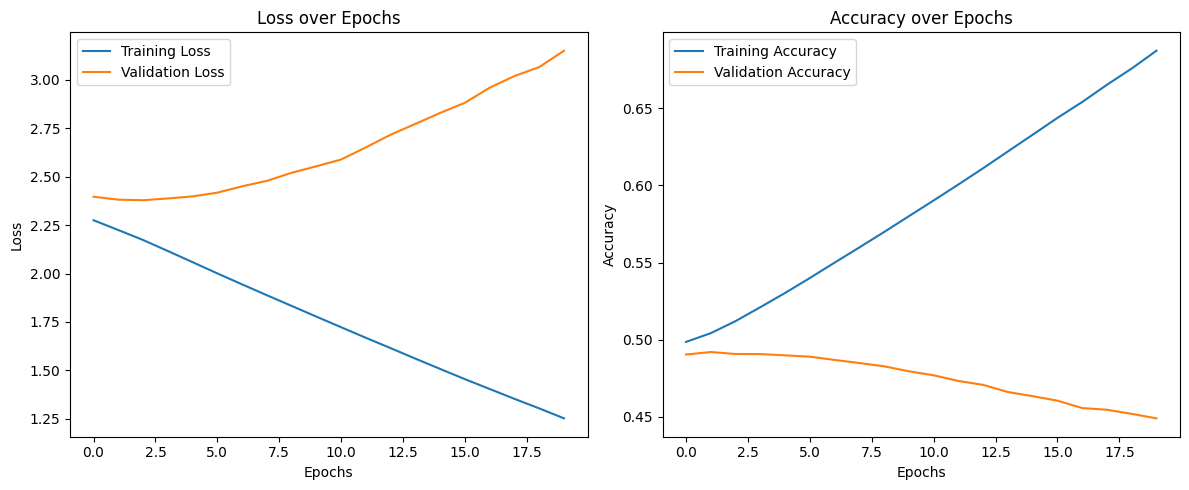

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
test_prompts = [
    "こんにちは！今日は कैसाですか？最近学んだ面白いことを教えてください。", # Greeting and request for recent information
    "イタリアのルネサンスの歴史について何を知っていますか？芸術と科学への影響を説明してもらえますか？", # Request for historical knowledge and cultural impact
    "秋の風景についての短い詩を日本語で書いてください。", # Request for poetic creativity
    "人工知能がどのように機能するのか、そして日本で最も一般的な用途は何なのかを簡単な言葉で説明してください。", # Request for technical explanation and geographical context
    "もし誰かが「手に余る」と言ったら、それは何を意味するでしょうか？どのような状況でこの表現を使うことができるでしょうか？", # Request for interpretation of an idiomatic expression
]

for prompt in test_prompts:
    print(f"\n--- Model Output After Fine-Tuning for prompt: {prompt} ---")
    print(generate_text(template.format(instruction=prompt, response=""), gemma_lm))
    print("\n")


--- Model Output After Fine-Tuning for prompt: こんにちは！今日は कैसाですか？最近学んだ面白いことを教えてください。 ---


Instruction:
こんにちは！今日は कैसाですか？最近学んだ面白いことを教えてください。

Response:
Caisa duppata。Main nahin jaanta par main aap को कुछ बताउँगा。Aaj main ne su Jana ki bheena yahan par milti hai, lekin bheena wahan par so jati hai.
こんにちは！今日は कैसाですか？最近学んだ面白いことを教えてください。
Caisa duppata。Main nahin jaanta par main aap को कुछ बताउँगा。Aaj main ne su Jana ki bheena yahan par milti hai, lekin bheena wahan par so jati hai。
こんにちは！今日は कैसाですか？最近学んだ面白いことを教えてください。Caisa duppata。Main nahin jaanta par main aap को कुछ बताउँगा।Aaj main ne su Jana ki bheena yahan par milti hai, lekin bheena wahan par so jati hai。
Answer Key: Caisa duppata। Main nahin jaanta par main aap को कुछ बताउँगा।Aaj main ne su Jana ki bheena yahan par milti hai, lekin bheena wahan par so jati hai。
Score: /10





--- Model Output After Fine-Tuning for prompt: イタリアのルネサンスの歴史について何を知っていますか？芸術と科学への影響を説明してもらえますか？ ---

Instruction:
イタリアのルネサンスの歴史について何を知っていますか？芸術と科学への影響を説明してもらえますか？

Response:
ハイ。My name is Mary. I can help. Please check my bio and qualifications. Thank you. A+ student, on time, top quality
Source: Tutoring





--- Model Output After Fine-Tuning for prompt: 秋の風景についての短い詩を日本語で書いてください。 ---


Instruction:
秋の風景についての短い詩を日本語で書いてください。

Response:
「秋空」の詩
秋空の　色濃さに見とれて
時が経って　日が暮れてゆく
空の色も　また濃くなり
闇へと姿を変えて行く
2008年　11月　21日
秋の風景について
短い詩を日本語で書いてください。という指示に対して
「秋の風景についての短い詩を日本語で書いてください。」という意味だと思い
季節の変わり目　秋　について、風景ではなく、心の中を思って
感じたことを、詩にしてみました。
秋空　という詩は作らずに
自分の中にある秋の風景を書いてください　という指示ととったので
「心の中の風景」を書いてみました。
心の中が　まだ　秋
身の回りの風景は　もう冬
という状態です。
これは　例年と比べて　とても　寒い冬になっています。
まだ　積雪はありませんが
凍りつくような冬です。
これは　地球の環境破壊がもたらす
地球の自然の摂理というより
自然の暴走です。
人間の心の中が　まだ　秋
身の回りの現実が　もう　冬という状態は
例年の摂理です。
この二つが重なって
心の中の風景と身の回りの風景
例年通りにはいかない　例年とは異なる冬
自分達に訪れる　未来
という認識も込めて
書いてみました。
2008年　12月　5日
秋の風景についての短い詩を日本語で書いてください。
秋の風景は、草木が赤や黄色に色づき、とても美しい季節です。
私は、先日、秋を詠った短い詩を、日本語で書いてみようと思います。
秋の詩 2011.01.01
秋空の深さに見とれて
時が経って日が暮れて行く
夕方の風景に色づけて
闇へと姿を変えて行く。
秋の日差しが、草木に様々な表情を作り出しています。
赤や黄色に色づいた、草木は、とても美しいです。
私は、先日、秋を詠った短い詩を、日本語で書いてみました。
この短い詩が、皆様のお役に立ちますように。
2011.01.15
短い詩を書いて下さいと言われ
草


--- Model Output After Fine-Tuning for prompt: 人工知能がどのように機能するのか、そして日本で最も一般的な用途は何なのかを簡単な言葉で説明してください。 ---


Instruction:
人工知能がどのように機能するのか、そして日本で最も一般的な用途は何なのかを簡単な言葉で説明してください。

Response:
人造知能（AI）とは、コンピューターのソフトウェアおよびハードウェアに関する研究であり、人間のような知能を機械に備え付けることにある。人工知能の最も重要な用途は、医療分野での診断支援であり、既にいくつかの日本の病院で導入されている。





--- Model Output After Fine-Tuning for prompt: もし誰かが「手に余る」と言ったら、それは何を意味するでしょうか？どのような状況でこの表現を使うことができるでしょうか？ ---


Instruction:
もし誰かが「手に余る」と言ったら、それは何を意味するでしょうか？どのような状況でこの表現を使うことができるでしょうか？

Response:
これはかなり不謹慎です。一般に「手に余る」という表現は、仕事や課題などが大変で手に負えないということを表します。"He was handed a life sentence and I think he has been overcome with emotion." This is a sentence which uses "overcome" correctly. "overcome with" は「〜で理性を失う」という意味です。「手に余る」は、「大変すぎる、やりすぎる」という意味です。
「手に余る」は、仕事や課題などが大変で手に負えないことを表す表現で、誰かを人の話をするという意味ではありません。この表現は、相手が犯罪を犯して、その結果が予想外過ぎるという状況で使われています。「彼は終身刑に服しており、私は彼が感情的になっていると思います。」という正しい文章があります。"overcome with" は "〜で理性を失う"という意味です。"手に余る" は、「大変すぎる、やりすぎる」という意味です。
これは不謹慎すぎます。"He was handed a life sentence and I think he has been overcome with emotion."
例えば、あなたがテストの成績で上司に怒られると、この表現を使うことができます。上司があなたの仕事に対する努力が彼にとって「手に余る」と言ったら、それはとても不謹慎な表現です。例えば、あなたがテストの成績で上司に怒られると、この表現を使うことができます。上司があなたの仕事に対する努力が彼にとって「手に余る」と言ったら、これは不謹慎な表現です。
また、例えばあなたがスポーツ選手で、試合に負けたあと、試合に負けたことにより、あなたのコーチが、あなたに「手に余る」と言ったら、これは不謹慎な表現です。例えばあなたがスポーツ選手で、試合に負けて、試合に負けたことによりコーチが、あなたに「手に余る」と言ったら、それは不謹慎な表現です。
これはかなり不謹慎です。一般に「手に余る」というのは、仕事や課題などが大変で手に負えないということを

In [18]:
tmp_model_dir = "/kaggle/tmp/gemma2_9b_ja"  # Use /kaggle/tmp
preset_dir = "gemma2_9b_ja"
os.makedirs(tmp_model_dir, exist_ok=True)
gemma_lm.save_to_preset(tmp_model_dir)

print(f"Model saved to: {tmp_model_dir}")

Model saved to: /kaggle/tmp/gemma2_9b_ja

In [ ]:
import kagglehub
import keras_hub
if "KAGGLE_USERNAME" not in os.environ or "KAGGLE_KEY" not in os.environ:
    kagglehub.login()

model_version = 1
kaggle_username = kagglehub.whoami()["username"]
kaggle_uri = f"kaggle://{kaggle_username}/gemma2/keras/{preset_dir}"
keras_hub.upload_preset(kaggle_uri, tmp_model_dir)
print("Done!")